# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

to download the files realted to banana enivronment visit ```https://github.com/udacity/Value-based-methods/tree/main/p1_navigation```

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(file_name="Banana_Windows_x86_64/Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

When finished, you can close the environment.

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque

# Define the Q-network
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed):
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_size)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Define the DQN agent
class DQNAgent:
    def __init__(self, state_size, action_size, seed):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.q_network = QNetwork(state_size, action_size, seed)
        self.q_network_target = QNetwork(state_size, action_size, seed)
        self.learning_rate = 5e-4 # Learning Rate
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=self.learning_rate)
        self.memory = deque(maxlen=10000)  # arbitrary size for replay buffer
        self.gamma = 0.99  # discount factor
        self.tau = 1e-3  # for soft update of target parameters
        self.update_every = 4  # how often to update the network
        self.batch_size = 64
        self.epsilon = 1.0  # exploration rate
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.loss_function = nn.MSELoss()
        self.t_step = 0
        
        
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.append((state, action, reward, next_state, done))
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % self.update_every
        if self.t_step == 0:
            if len(self.memory) > self.batch_size:
                experiences = self.sample()
                self.learn(experiences, self.gamma)

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        self.q_network.eval()
        with torch.no_grad():
            action_values = self.q_network(state)
        self.q_network.train()

        # Epsilon-greedy action selection
        if random.random() > self.epsilon:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        states = torch.from_numpy(np.vstack([e[0] for e in experiences if e is not None])).float()
        actions = torch.from_numpy(np.vstack([e[1] for e in experiences if e is not None])).long()
        rewards = torch.from_numpy(np.vstack([e[2] for e in experiences if e is not None])).float()
        next_states = torch.from_numpy(np.vstack([e[3] for e in experiences if e is not None])).float()
        dones = torch.from_numpy(np.vstack([e[4] for e in experiences if e is not None]).astype(np.uint8)).float()

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.q_network_target(next_states).detach().max(1)[0].unsqueeze(1)

        # Compute Q targets for current states
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.q_network(states).gather(1, actions)

        # Compute loss
        loss = self.loss_function(Q_expected, Q_targets)

        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update epsilon
        self.epsilon = max(self.epsilon_min, self.epsilon_decay*self.epsilon)
        
        # Soft Update
        self.soft_update(self.q_network, self.q_network_target)


    def sample(self):
        # Randomly sample a batch of experiences from memory
        experiences = random.sample(self.memory, k=self.batch_size)
        # print(len(experiences))
        return experiences
    
    def soft_update(self, local_model, target_model):
        '''Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        :param local_model: PyTorch model. weights will be copied from
        :param target_model: PyTorch model. weights will be copied to
        :param tau: float. interpolation parameter
        '''
        iter_params = zip(target_model.parameters(), local_model.parameters())
        for target_param, local_param in iter_params:
            tensor_aux = self.tau*local_param.data + (1.0-self.tau)*target_param.data
            target_param.data.copy_(tensor_aux)

In [10]:
agent = DQNAgent(state_size=37, action_size=4, seed=0)

num_episode = 1800
score_list = []

for i_episode in range(num_episode):
    env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
    state = env_info.vector_observations[0]            # get the current state
    score = 0                                          # initialize the score
    while True:
        action = agent.act(state)                      # select an action
        action = action.astype(int)
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  # see if episode has finished
        agent.step(state, action, reward, next_state, done)
        score += reward                                # update the score
        state = next_state                             # roll over the state to next time step
        if done:                                       # exit loop if episode finished
            break

    print("Episode: {} Score: {}".format(i_episode, score))
    if i_episode > 100:
        score_100 = np.mean(score_list[-100:])
        print(f'Avergare score for last 100 Episode: {np.mean(score_list[-100:])}')
        if score_100 >= 13.1:
            break
    score_list.append(score)

Episode: 0 Score: -1.0
Episode: 1 Score: 1.0
Episode: 2 Score: 0.0
Episode: 3 Score: 5.0
Episode: 4 Score: 0.0
Episode: 5 Score: 1.0
Episode: 6 Score: 3.0
Episode: 7 Score: 2.0
Episode: 8 Score: 0.0
Episode: 9 Score: 3.0
Episode: 10 Score: 0.0
Episode: 11 Score: 0.0
Episode: 12 Score: 0.0
Episode: 13 Score: 2.0
Episode: 14 Score: 1.0
Episode: 15 Score: 2.0
Episode: 16 Score: 0.0
Episode: 17 Score: 0.0
Episode: 18 Score: 1.0
Episode: 19 Score: 0.0
Episode: 20 Score: 2.0
Episode: 21 Score: 0.0
Episode: 22 Score: 4.0
Episode: 23 Score: 5.0
Episode: 24 Score: 0.0
Episode: 25 Score: 3.0
Episode: 26 Score: 0.0
Episode: 27 Score: 6.0
Episode: 28 Score: 2.0
Episode: 29 Score: 1.0
Episode: 30 Score: 0.0
Episode: 31 Score: 2.0
Episode: 32 Score: 1.0
Episode: 33 Score: 5.0
Episode: 34 Score: 1.0
Episode: 35 Score: 2.0
Episode: 36 Score: 2.0
Episode: 37 Score: 3.0
Episode: 38 Score: 2.0
Episode: 39 Score: 7.0
Episode: 40 Score: 7.0
Episode: 41 Score: 1.0
Episode: 42 Score: 2.0
Episode: 43 Score: 4

Episode: 190 Score: 7.0
Avergare score for last 100 Episode: 8.51
Episode: 191 Score: 9.0
Avergare score for last 100 Episode: 8.56
Episode: 192 Score: 15.0
Avergare score for last 100 Episode: 8.62
Episode: 193 Score: 13.0
Avergare score for last 100 Episode: 8.67
Episode: 194 Score: 11.0
Avergare score for last 100 Episode: 8.71
Episode: 195 Score: 5.0
Avergare score for last 100 Episode: 8.81
Episode: 196 Score: 10.0
Avergare score for last 100 Episode: 8.79
Episode: 197 Score: 17.0
Avergare score for last 100 Episode: 8.86
Episode: 198 Score: 13.0
Avergare score for last 100 Episode: 9.01
Episode: 199 Score: 5.0
Avergare score for last 100 Episode: 9.12
Episode: 200 Score: 10.0
Avergare score for last 100 Episode: 9.1
Episode: 201 Score: 15.0
Avergare score for last 100 Episode: 9.09
Episode: 202 Score: 2.0
Avergare score for last 100 Episode: 9.2
Episode: 203 Score: 18.0
Avergare score for last 100 Episode: 9.21
Episode: 204 Score: 11.0
Avergare score for last 100 Episode: 9.37
Ep

Episode: 312 Score: 9.0
Avergare score for last 100 Episode: 11.59
Episode: 313 Score: 12.0
Avergare score for last 100 Episode: 11.56
Episode: 314 Score: 10.0
Avergare score for last 100 Episode: 11.58
Episode: 315 Score: 15.0
Avergare score for last 100 Episode: 11.57
Episode: 316 Score: 13.0
Avergare score for last 100 Episode: 11.56
Episode: 317 Score: 15.0
Avergare score for last 100 Episode: 11.55
Episode: 318 Score: 15.0
Avergare score for last 100 Episode: 11.53
Episode: 319 Score: 11.0
Avergare score for last 100 Episode: 11.57
Episode: 320 Score: 16.0
Avergare score for last 100 Episode: 11.66
Episode: 321 Score: 12.0
Avergare score for last 100 Episode: 11.71
Episode: 322 Score: 17.0
Avergare score for last 100 Episode: 11.68
Episode: 323 Score: 13.0
Avergare score for last 100 Episode: 11.68
Episode: 324 Score: 6.0
Avergare score for last 100 Episode: 11.65
Episode: 325 Score: 15.0
Avergare score for last 100 Episode: 11.56
Episode: 326 Score: 15.0
Avergare score for last 1

Episode: 434 Score: 14.0
Avergare score for last 100 Episode: 11.42
Episode: 435 Score: 5.0
Avergare score for last 100 Episode: 11.47
Episode: 436 Score: 12.0
Avergare score for last 100 Episode: 11.51
Episode: 437 Score: 18.0
Avergare score for last 100 Episode: 11.43
Episode: 438 Score: 11.0
Avergare score for last 100 Episode: 11.48
Episode: 439 Score: 18.0
Avergare score for last 100 Episode: 11.46
Episode: 440 Score: 13.0
Avergare score for last 100 Episode: 11.46
Episode: 441 Score: 17.0
Avergare score for last 100 Episode: 11.5
Episode: 442 Score: 18.0
Avergare score for last 100 Episode: 11.51
Episode: 443 Score: 18.0
Avergare score for last 100 Episode: 11.62
Episode: 444 Score: 5.0
Avergare score for last 100 Episode: 11.64
Episode: 445 Score: 21.0
Avergare score for last 100 Episode: 11.55
Episode: 446 Score: 12.0
Avergare score for last 100 Episode: 11.68
Episode: 447 Score: 12.0
Avergare score for last 100 Episode: 11.6
Episode: 448 Score: 12.0
Avergare score for last 100

The agent was ablet to reach mean reward of above 13.1 in 515 episodes for the last 100 cycles.

In [13]:
torch.save(agent.q_network.state_dict(),'final_model.pt')

# Result

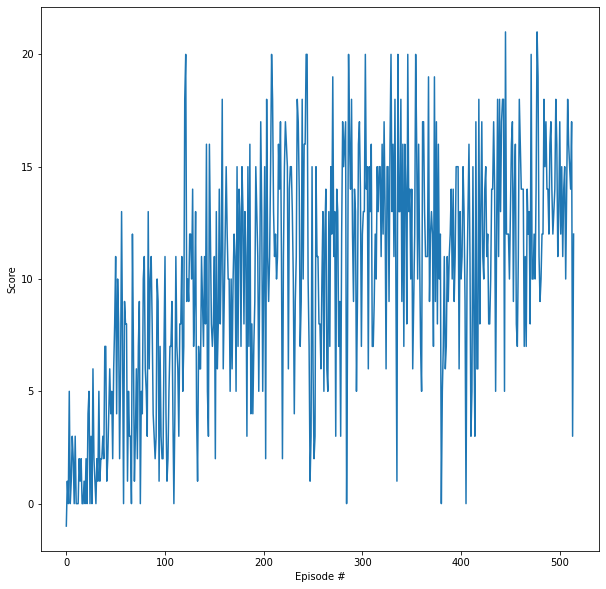

In [21]:
import matplotlib.pyplot as plt
# import seaborn as sns
plt.figure(figsize=(10,10))
plt.plot(score_list)
plt.xlabel('Episode #')
plt.ylabel('Score')
plt.show()

In [18]:
import pandas as pd

df = pd.DataFrame(score_list, columns=['Scores'])

window_size = 100
df['Rolling_Mean'] = df['Scores'].rolling(window=window_size).mean()
df['Rolling_STD'] = df['Scores'].rolling(window=window_size).std()

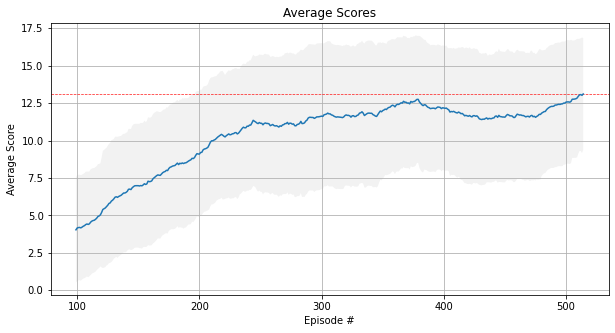

In [20]:
na_mu = df['Rolling_Mean']
na_sigma = df['Rolling_STD']

plt.figure(figsize=(10,5))
plt.axhline(y=13.1, xmin=0.0, xmax=1.0, color='r', linestyle='--', linewidth=0.7, alpha=0.9)
plt.plot(np.arange(len(na_mu)), na_mu, label='Rolling Mean of Last 100 Episodes')
plt.fill_between(np.arange(len(na_mu)), na_mu+na_sigma, na_mu-na_sigma, facecolor='gray', alpha=0.1)
plt.xlabel('Episode #')
plt.ylabel('Average Score')
plt.title('Average Scores')
plt.grid(True)
plt.show()


In [22]:
env.close()